# SQL vs NoSql vs NewSql

This notebook is used to run code and generate graphs

### Config

In [1]:
num_of_runs = 1

### Imports

In [2]:
import subprocess
import os
import time
import re
import postgres_import as pos_i
import mysql_import as my_i
import memsql_import as mem_i
import random

### Helper function to generate a bar plot graph

In [3]:
import numpy as np
from matplotlib import pyplot as plt

def bar_plot(data, items, colours, title):
    fig = plt.figure()

    width = .45
    ind = np.arange(len(data))
    
    plt.bar(0.3+ind, data, width=width, color=colours)
    plt.xticks(0.3+ind + width / 2, items)
    plt.title(title)

    fig.autofmt_xdate()

    plt.show()

### Helper function to run commands inside a shell

In [4]:
def run_command(command, verbose=True, save_mem=False):
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, shell=True)
    returncode = process.wait()
    output = ""
    if not(save_mem):
        output = process.stdout.read().decode('utf-8', 'replace').replace("\r", "").split("\n")
        if verbose: 
            for line in output:
                print (line)
    return output

def run_command2(command, verbose=True, save_mem=False):
    process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
    returncode = process.wait()
    output = ""
    if not(save_mem):
        output = process.stdout.read().decode('utf-8', 'replace').replace("\r", "").split("\n")
        if verbose: 
            for line in output:
                print (line)
    return output

## Starting all the docker containers to check if it's all right

In [5]:
_ = run_command('D: && cd "D:\Repos\BigData\Project2\Docker" && docker-compose up -d')

trafodion is up-to-date
voltdb is up-to-date
mongo is up-to-date
cockroach is up-to-date
cassandra is up-to-date
postgres is up-to-date
orientdb is up-to-date
redis is up-to-date
nuodb is up-to-date
memsql is up-to-date
neo4j is up-to-date
mysql is up-to-date



We will need the local ip of the Coackroach container for later use.

In [6]:
ip = run_command('docker exec cockroach ip route', verbose=False)
ip = ip[len(ip)-2].split(" ")
ip = ip[len(ip)-2]
coackroach_ip = ip
print(coackroach_ip)

172.21.0.8


## Stopping all the containers
Test functions will start and stop the containers many times in order to accurately measure times.

In [7]:
_ = run_command('D: && cd "D:\Repos\BigData\Project2\Docker" && docker-compose down')

Stopping neo4j ... 
Stopping memsql ... 
Stopping voltdb ... 
Stopping mongo ... 
Stopping cockroach ... 
Stopping redis ... 
Stopping postgres ... 
Stopping orientdb ... 
Stopping cassandra ... 
Stopping nuodb ... 
Stopping mysql ... 
Stopping trafodion ... 
Stopping postgres ... doneStopping redis ... doneStopping mongo ... doneStopping cockroach ... doneStopping voltdb ... doneStopping neo4j ... doneStopping mysql ... doneStopping orientdb ... doneStopping cassandra ... doneStopping nuodb ... doneStopping memsql ... doneStopping trafodion ... doneRemoving neo4j ... 
Removing memsql ... 
Removing voltdb ... 
Removing mongo ... 
Removing cockroach ... 
Removing redis ... 
Removing postgres ... 
Removing orientdb ... 
Removing cassandra ... 
Removing nuodb ... 
Removing mysql ... 
Removing trafodion ... 
Removing memsql ... doneRemoving postgres ... doneRemoving nuodb ... doneRemoving mysql ... doneRemoving trafodion ... doneRemoving cockroach ... doneRemoving neo4j ... doneRemoving ca

## Definitions

In [8]:
postgres_container = "postgres"
containers = ["mongo", "redis", "neo4j", "orientdb", "cassandra", postgres_container, "mysql", "memsql", "voltdb", "cockroach"]
colours = ["lightgreen", "red", "deepskyblue", "orange", "skyblue", "lightsteelblue", "steelblue", "cornflowerblue", "firebrick", "darkgreen"]

### Helper functions to run tests and measure the time taken

In [9]:
def exec_and_time(container, command, verbose=True, save_mem=False):
    start = time.time()
    if container == postgres_container or container == "mysql" or container == "memsql":
        command[0](os.path.join(os.path.abspath('./Docker/shared_data'),command[1]))
    elif container == "cockroach":
        _ = run_command('docker exec --privileged ' + container + ' sh -c "' + command[0] + '"', verbose, save_mem)
        _ = run_command('docker exec --privileged --user postgres '+ postgres_container +' sh -c "' + command[1] + '"', verbose, save_mem)
    elif container == "cassandra":
        _ = run_command2('docker exec --privileged ' + container + ' '+ command[0] +' -c "' + command[1] + '"', verbose, save_mem)
    else: 
        _ = run_command('docker exec --privileged ' + container + ' sh -c "' + command + '"', verbose, save_mem)
    end = time.time()
    return end - start

In [10]:
def average_time(commands, containers, iterations, verbose=True, import_data=False):
    times = [0] * len(containers)
    peak_times = [0] * len(containers)
    for j in range(0, iterations):
        if verbose:
            print("iteration " + str(j+1))
        _ = run_command('D: && cd "D:\Repos\BigData\Project2\Docker" && docker-compose up -d', verbose=False)
        if verbose:
            print("waiting...")
        time.sleep(25) 
        for i in range(0, len(containers)):
            if verbose:
                print(containers[i])
            if import_data:
                exec_and_time(containers[i], data_import_commands[i], verbose=False, save_mem=True)
            time_taken = exec_and_time(containers[i], commands[i], verbose=False, save_mem=True)
            times[i] += time_taken
            if peak_times[i] < time_taken:
                peak_times[i] = time_taken
        _ = run_command('D: && cd "D:\Repos\BigData\Project2\Docker" && docker-compose down', verbose=False)
    for i in range(0, len(containers)):
        times[i] = times[i]/iterations
        print(containers[i] + ": " + str(times[i]))
    return (times, peak_times)

## Average bulk import time

### Import commands

In [11]:
data_import_commands = [
    "mongoimport --db testing_db --collection customers --type csv --headerline --file /shared_data/mock_data_10000_rows.csv && mongo testing_db --eval 'db.customers.createIndex({Id:1});'",
    "cat /shared_data/mock_data_10000_rows2.csv | redis-cli --pipe",
    "cp /shared_data/mock_data_10000_neo.csv /var/lib/neo4j/import && cat /shared_scripts/import_mock_10000.cypher | /var/lib/neo4j/bin/cypher-shell",
    "/orientdb/bin/oetl.sh /shared_scripts/import_orient_10000.json",
    ["bash", "cqlsh -f /shared_scripts/import_mock_10000.cql"],
    [pos_i.sql_import, "mock_data_10000_rows_utf8.csv"], #postgres
    [my_i.sql_import, "mock_data_10000_rows_utf8.csv"], #mysql
    [mem_i.sql_import, "mock_data_10000_rows_utf8.csv"], #memsql
    "cat /shared_scripts/import_voltdb.sql | sqlcmd && /opt/voltdb/bin/csvloader customers -f /shared_data/mock_data_10000_rows.csv",
    ["./cockroach sql --insecure --execute='create database if not exists mock;'", "psql -p 26257 -h "+ coackroach_ip +" -d mock -U root < /shared_data/postgres_dump.sql"]
]

#### Iterating

In [12]:
(import_times_avg, import_times_peak) = average_time(data_import_commands, containers, num_of_runs)

iteration 1
waiting...
mongo
redis
neo4j
orientdb
cassandra
postgres
mysql
memsql
voltdb
cockroach
mongo: 0.8759615421295166
redis: 0.24250197410583496
neo4j: 5.137271881103516
orientdb: 19.413878440856934
cassandra: 5.125726222991943
postgres: 8.819522619247437
mysql: 1.9458372592926025
memsql: 3.8546783924102783
voltdb: 5.168786525726318
cockroach: 2.7256124019622803


### Results

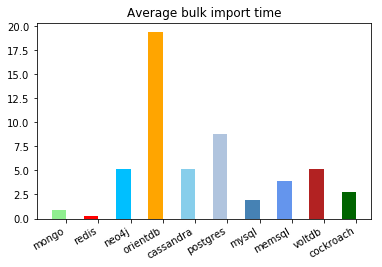

In [13]:
bar_plot(import_times_avg, containers, colours, "Average bulk import time")

## Query execution time and throughput

### Helper functions, modified from the previous ones
And also dependant from them.

In [14]:
def exec_and_time2(container, command, verbose=True, save_mem=False):
    start = time.time()
    if container == "cassandra":
        _ = run_command2(command, verbose, save_mem)
    else:
        _ = run_command(command, verbose, save_mem)
    end = time.time()
    return end - start

In [15]:
def average_time2(commands, containers, iterations, verbose=True, import_data=True):
    times = [0] * len(containers)
    peak_times = [0] * len(containers)
    for j in range(0, iterations):
        if verbose:
            print("iteration " + str(j+1))
        _ = run_command('D: && cd "D:\Repos\BigData\Project2\Docker" && docker-compose up -d', verbose=False)
        if verbose:
            print("waiting...")
        time.sleep(25) 
        for i in range(0, len(containers)):
            if verbose:
                print(containers[i])
            if import_data:
                exec_and_time(containers[i], data_import_commands[i], verbose=False, save_mem=True)
            time_taken = exec_and_time2(containers[i], commands[i].replace("{{id}}", str(random.randrange(0, 9999, 1))), verbose=False, save_mem=True)
            times[i] += time_taken
            if peak_times[i] < time_taken:
                peak_times[i] = time_taken
        _ = run_command('D: && cd "D:\Repos\BigData\Project2\Docker" && docker-compose down', verbose=False)
    for i in range(0, len(containers)):
        times[i] = times[i]/iterations
        print(containers[i] + ": " + str(times[i]))
    return (times, peak_times)

### Unindexed Search Commands
Redis has no unindexed search.

In [16]:
unindexed_read_commands = [
    r"""docker exec --privileged mongo mongo testing_db --eval "db.customers.find({first_name:'Hosea'}).pretty().shellPrint();" """,
    "",
    r"""docker exec --privileged neo4j sh -c "echo \"MATCH (n) WHERE n.firstName = 'Hosea' RETURN n;\" | /var/lib/neo4j/bin/cypher-shell" """,
    r"""docker exec --privileged orientdb /orientdb/bin/console.sh "connect plocal:/temp/databases/mock admin admin; select from Customer where first_name = 'Hosea' " """,
    r"""docker exec --privileged cassandra cqlsh -k mock_keyspace -e "select * from customers where first_name = 'Hosea' allow filtering;" """,
    r"""docker exec --privileged postgres sh -c "echo \"SELECT * FROM customers WHERE first_name = 'Hosea'\" | psql -U postgres mock" """, #postgres
    r"""docker exec --privileged mysql mysql -u root --password=password --database mock -e "SELECT * FROM customers where first_name = 'Hosea'" """,
    r"""docker exec --privileged memsql memsql-shell --database mock -e "SELECT * FROM customers where first_name = 'Hosea'" """,
    r"""docker exec --privileged voltdb sh -c "echo \"select * from customers where first_name = 'Hosea';\" | sqlcmd"  """,
    r"""docker exec --privileged cockroach ./cockroach sql --insecure --execute="SET DATABASE = mock; SELECT * FROM customers WHERE first_name = 'Hosea';" """ 
]

#### Iterating

In [17]:
(unindexed_read_times_avg, unindexed_read_times_peak) = average_time2(unindexed_read_commands, containers, num_of_runs)
unindexed_read_times_avg[1] = 0; # redis has no unindexed search

iteration 1
waiting...
mongo
redis
neo4j
orientdb
cassandra
postgres
mysql
memsql
voltdb
cockroach
mongo: 0.24115467071533203
redis: 0.006000518798828125
neo4j: 2.052229404449463
orientdb: 4.157419204711914
cassandra: 0.7094306945800781
postgres: 0.3359999656677246
mysql: 0.13878583908081055
memsql: 0.6067438125610352
voltdb: 0.8836820125579834
cockroach: 0.2520005702972412


### Results

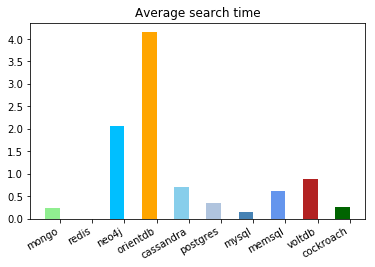

In [18]:
bar_plot(unindexed_read_times_avg, containers, colours, "Average search time")

### Indexed Search Commands

In [19]:
indexed_read_commands = [
    r"""docker exec --privileged mongo mongo testing_db --eval "db.customers.find({Id:{{id}}}).pretty().shellPrint()" """,
    r"""docker exec --privileged redis sh -c "echo GET 0 | redis-cli" """,
    r"""docker exec --privileged neo4j sh -c "echo \"MATCH (n) WHERE ID(n) = 1 RETURN n;\" | /var/lib/neo4j/bin/cypher-shell" """,
    r"""docker exec --privileged orientdb /orientdb/bin/console.sh "connect plocal:/temp/databases/mock admin admin; select from Customer where Id = 1" """,
    r"""docker exec --privileged cassandra cqlsh -k mock_keyspace -e "select * from customers where id = 1 allow filtering;" """,
    r"""docker exec --privileged postgres sh -c "echo \"SELECT * FROM customers where id = 1\" | psql -U postgres mock" """, #postgres
    r"""docker exec --privileged mysql mysql -u root --password=password --database mock -e "SELECT * FROM customers where id = 1" """,
    r"""docker exec --privileged memsql memsql-shell --database mock -e "SELECT * FROM customers where id = 1" """,
    r"""docker exec --privileged voltdb sh -c "echo \"SELECT * FROM customers where id = 1\" | sqlcmd"  """,
    r"""docker exec --privileged cockroach ./cockroach sql --insecure --execute="SET DATABASE = mock; SELECT * FROM customers where id = 1;" """ 
]

#### Iterating

In [20]:
(indexed_read_times_avg, indexed_read_times_peak) = average_time2(indexed_read_commands, containers, num_of_runs)

iteration 1
waiting...
mongo
redis
neo4j
orientdb
cassandra
postgres
mysql
memsql
voltdb
cockroach
mongo: 0.14750361442565918
redis: 0.10449814796447754
neo4j: 1.8064980506896973
orientdb: 3.7402477264404297
cassandra: 0.6930327415466309
postgres: 0.24160075187683105
mysql: 0.19003725051879883
memsql: 0.5527966022491455
voltdb: 0.6670000553131104
cockroach: 0.16100859642028809


### Results

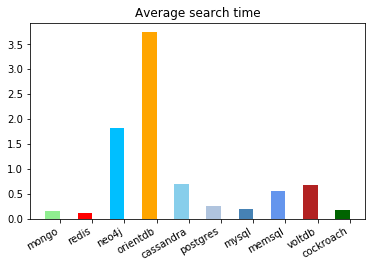

In [21]:
bar_plot(indexed_read_times_avg, containers, colours, "Average search time")

### Aggregate Functions Commands

docker exec --privileged redis sh -c "cat /shared_data/mock_data_10000_set.csv | redis-cli --pipe"

In [22]:
aggregate_read_commands = [
    r"""docker exec --privileged mongo mongo testing_db --eval 'db.customers.aggregate(    [      { $group: { "_id": "$first_name", "avg": { $avg: "$income" } } }    ] ).pretty().shellPrint();' """,
    "",#r"""docker exec --privileged redis sh -c "echo zcount mylist -inf +inf | redis-cli" """,
    r"""docker exec --privileged neo4j sh -c "echo \"match (n:Customer) return avg(n.income);\" | /var/lib/neo4j/bin/cypher-shell" """,
    r"""docker exec --privileged orientdb /orientdb/bin/console.sh "connect plocal:/temp/databases/mock admin admin; select avg(income) FROM Customer" """,
    r"""docker exec --privileged cassandra cqlsh -k mock_keyspace -e "select avg(income) as avg_income from customers;" """,
    r"""docker exec --privileged postgres sh -c "echo \"select avg(income) as avg_income from customers\" | psql -U postgres mock" """, #postgres
    r"""docker exec --privileged mysql mysql -u root --password=password --database mock -e "select avg(income) as avg_income from customers" """,
    r"""docker exec --privileged memsql memsql-shell --database mock -e "select avg(income) as avg_income from customers" """,
    r"""docker exec --privileged voltdb sh -c "echo \"select avg(income) as avg_income from customers\" | sqlcmd"  """,
    r"""docker exec --privileged cockroach ./cockroach sql --insecure --execute="SET DATABASE = mock; select avg(income) as avg_income from customers;" """ 
]

#### Iterating

In [23]:
(aggregate_read_times_avg, aggregate_read_times_peak) = average_time2(aggregate_read_commands, containers, num_of_runs)

iteration 1
waiting...
mongo
redis
neo4j
orientdb
cassandra
postgres
mysql
memsql
voltdb
cockroach
mongo: 0.07599997520446777
redis: 0.008001565933227539
neo4j: 2.9260001182556152
orientdb: 4.625821352005005
cassandra: 1.2500004768371582
postgres: 0.16650772094726562
mysql: 0.1335291862487793
memsql: 0.5012412071228027
voltdb: 0.8595819473266602
cockroach: 0.1314997673034668


### Results

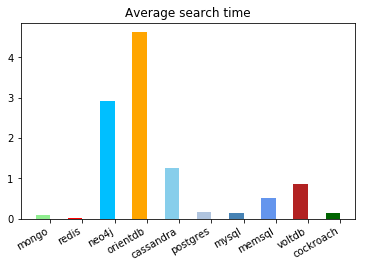

In [24]:
bar_plot(aggregate_read_times_avg, containers, colours, "Average search time")

### Join Commands
MongoDB, Redis, OrientDB, Cassandra do not allow join operations.

docker exec --privileged neo4j sh -c "echo \"MATCH (n:Customer) CREATE (n)-[r:Autoedge]->(n) RETURN r;\" | /var/lib/neo4j/bin/cypher-shell

In [ ]:
join_commands = [
    "",
    "",
    "",#r"""docker exec --privileged neo4j sh -c "echo \"MATCH (n:Customer)-[:Autoedge]->(m:Customer) WHERE n.firstName = m.firstName RETURN n, m;\" | /var/lib/neo4j/bin/cypher-shell" """,
    "",
    "",
    r"""docker exec --privileged postgres sh -c "echo \"select * from customers a, customers b where a.first_name = b.first_name;\" | psql -U postgres mock" """, #postgres
    r"""docker exec --privileged mysql mysql -u root --password=password --database mock -e "select * from customers a, customers b where a.first_name = b.first_name;" """,
    r"""docker exec --privileged memsql memsql-shell --database mock -e "select * from customers a, customers b where a.first_name = b.first_name;" """,
    r"""docker exec --privileged voltdb sh -c "echo \"select * from customers a, customers b where a.first_name = b.first_name;\" | sqlcmd"  """,
    r"""docker exec --privileged cockroach ./cockroach sql --insecure --execute="SET DATABASE = mock; select * from customers a, customers b where a.first_name = b.first_name;" """ 
]

#### Iterating

In [ ]:
(join_times_avg, join_times_peak) = average_time2(join_commands, containers, num_of_runs)
join_times_avg[0] = 0; # mongodb does not support relational join operation
join_times_avg[1] = 0; # redis does not support relational join operation
join_times_avg[3] = 0; # orientdb does not support relational join operation
join_times_avg[4] = 0; # cassandra does not support relational join operation

iteration 1
waiting...
mongo
redis
neo4j
orientdb
cassandra
postgres
